<a href="https://colab.research.google.com/github/chamodi08jaya/Data-Analytics/blob/main/17020387_SIFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounting google drive to read files from drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


When getting an error "module 'cv2.cv2' has no attribute 'SIFT_create' "

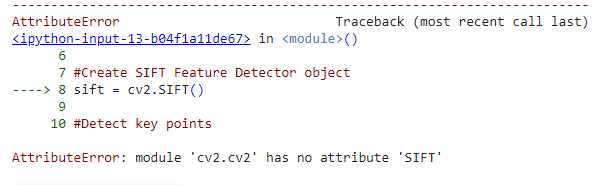

The first thing to do is see the exact version you are using, all just running:

print (cv2 .__ version__)

if version = 4.4.0 then sift = cv2.SIFT_create ()

if version = 4.3.x then sift = cv2.xfeatures2d.SIFT_create ()

if Version = 4.2.x or 4.1.xu 4.0.x, then SIFT will not work, it is not taken into consideration during the construction of the python package, the activation of the open-contrib module as well as the use of algorithms non free have not been activated.

on google colab you can install the opencv version you want by simply using a pip command preceded by an exclamation point "!" and specify the opencv version as follows:

!pip install opencv-contrib-python==4.4.0.44

In [ ]:
#import the necessary modules.
import cv2
cv2.__version__

'4.4.0'

In [ ]:
!pip install opencv-contrib-python==4.4.0.44

In [ ]:
#import the necessary modules.
import cv2
cv2.__version__

'4.4.0'

In [ ]:
#import the necessary modules.
from random import randrange
import matplotlib.pyplot as plt
import numpy as np
figsize = (10, 10)

#SIFT feature detection and description

In [ ]:
#Reading an image in default mode
img_1 = cv2.cvtColor(cv2.imread('/content/drive/My Drive/Data Analytics/SIFT_Assignment/img1.jpg'), cv2.COLOR_BGR2RGB)
#Using cv2.cvtColor() method
#Using cv2.COLOR_BGR2GRAY color space
#conversion code
gray_1 = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
img_2 = cv2.cvtColor(cv2.imread('/content/drive/My Drive/Data Analytics/SIFT_Assignment/img3.jpg'), cv2.COLOR_BGR2RGB)
gray_2 = cv2.cvtColor(img_2, cv2.COLOR_RGB2GRAY)


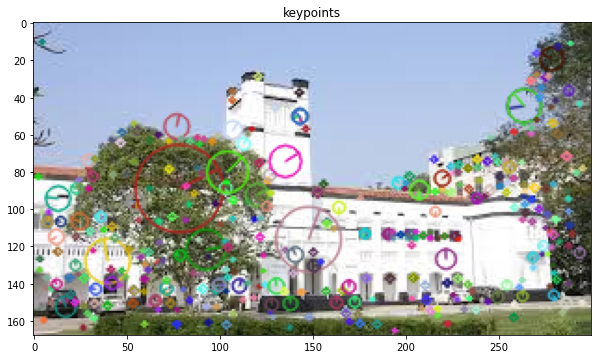

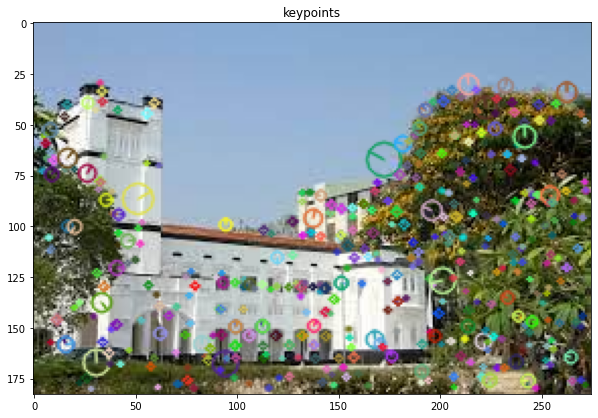

In [ ]:
# use orb if sift is not installed
feature_extractor = cv2.SIFT_create()

# find the keypoints and descriptors with chosen feature_extractor
#sift.detectAndCompute(),directly find keypoints and descriptors in a single step with the function.
kp_1, desc_1 = feature_extractor.detectAndCompute(gray_1, None)
kp_2, desc_2 = feature_extractor.detectAndCompute(gray_2, None)

#cv.drawKeyPoints() function which draws the small circles on the locations of keypoints
test = cv2.drawKeypoints(img_1, kp_1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
test2 = cv2.drawKeypoints(img_2, kp_2, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=figsize)
plt.imshow(test)
plt.title("keypoints")
plt.show()

plt.figure(figsize=figsize)
plt.imshow(test2)
plt.title("keypoints")
plt.show()

# take only unique features


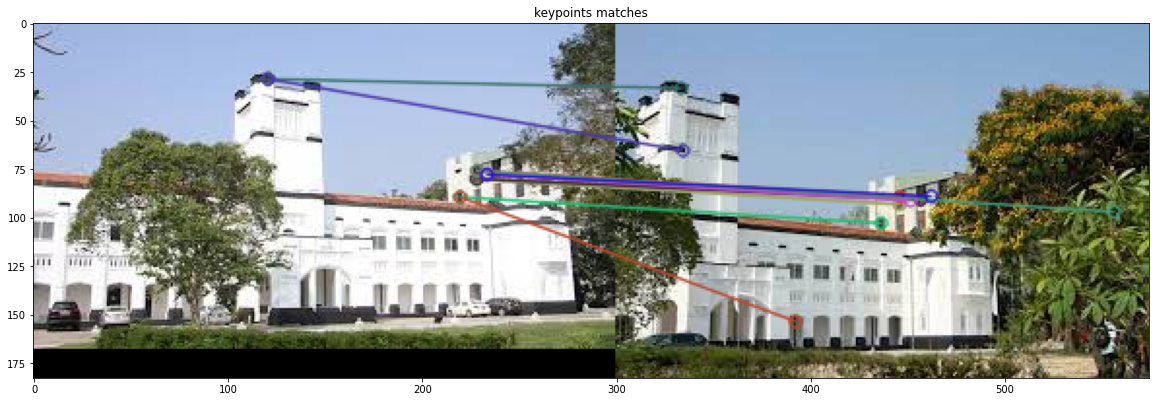

In [ ]:
#The BFMatcher() matches the features which are more similar. When we set parameter k=2, we are asking the knnMatcher to give out 2 best matches for each descriptor.
bf = cv2.BFMatcher()
matches = bf.knnMatch(desc_1, desc_2, k=2)

#Apply ratio test
#Compute distances between every descriptor in one image and every descriptor in the other image.
good_match = []
for m in matches:
    if m[0].distance/m[1].distance < 0.5:
        good_match.append(m)
good_match_arr = np.asarray(good_match)

# show only 30 matches
#Select the top ‘m’ matches for each descriptor of an image.
im_matches = cv2.drawMatchesKnn(img_1, kp_1, img_2, kp_2,
                                good_match[0:30], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(20, 20))
plt.imshow(im_matches)
plt.title("keypoints matches")
plt.show()

Find homography between images

In [ ]:
#Estimate homography
good_kp_l = np.array([kp_1[m.queryIdx].pt for m in good_match_arr[:, 0]]).reshape(-1, 1, 2)
good_kp_r = np.array([kp_2[m.trainIdx].pt for m in good_match_arr[:, 0]]).reshape(-1, 1, 2)
H, masked = cv2.findHomography(good_kp_r, good_kp_l, cv2.RANSAC, 5.0)

print(H)

[[ 6.46899361e-01  5.26561248e-01  8.43986305e+01]
 [-1.56492218e-01  1.13985319e+00 -3.45849268e+00]
 [-1.38536285e-03  2.16338056e-03  1.00000000e+00]]


overlay images

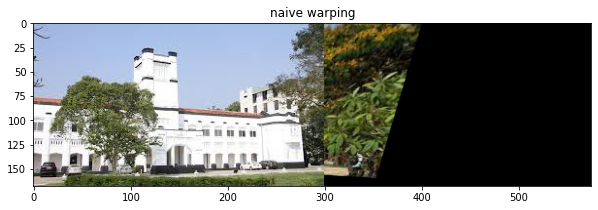

In [ ]:
#Warp to align for stitching
#cv2.warpPerspective() function that applies the perspective transformation to an image
rgb_r_warped = cv2.warpPerspective(img_2, H, (img_1.shape[1] + img_2.shape[1], img_1.shape[0]))
rgb_r_warped[0:img_1.shape[0], 0:img_1.shape[1]] = img_1

plt.figure(figsize=figsize)
plt.imshow(rgb_r_warped)
plt.title("naive warping")
plt.show()

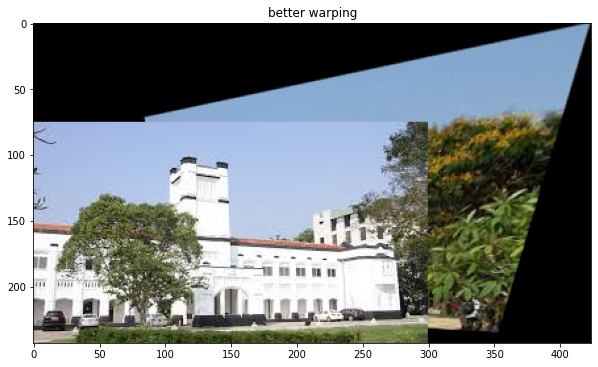

In [ ]:
#Stitch them together
def warpTwoImages(img1, img2, H):
    '''warp img2 to img1 with homograph H
    from: https://stackoverflow.com/questions/13063201/how-to-show-the-whole-image-when-using-opencv-warpperspective
    '''
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    # Locate points of the documents or object which you want to transform
    pts1 = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
    pts2 = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)
    # Apply Perspective Transform Algorithm
    pts2_ = cv2.perspectiveTransform(pts2, H)
    pts = np.concatenate((pts1, pts2_), axis=0)
    [xmin, ymin] = np.int32(pts.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts.max(axis=0).ravel() + 0.5)
    t = [-xmin, -ymin]
    Ht = np.array([[1, 0, t[0]], [0, 1, t[1]], [0, 0, 1]])  # translate
    # Wrap the transformed image
    result = cv2.warpPerspective(img2, Ht@H, (xmax-xmin, ymax-ymin))
    result[t[1]:h1+t[1], t[0]:w1+t[0]] = img1
    return result


result = warpTwoImages(img_1, img_2, H)

plt.figure(figsize=figsize)
plt.imshow(result)
plt.title("better warping")
plt.show()

